# HFGI: High-Fidelity GAN Inversion for Image Attribute Editing

Based on [HFGI](https://github.com/Tengfei-Wang/HFGI.git) to edit your own photo!

In [117]:
#@title Mount Google Drive (Optional)
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [ ]:
#@title Setup Repository
import os
CODE_DIR = 'HFGI'

# !git clone https://github.com/Tengfei-Wang/HFGI.git $CODE_DIR
!wget https://github.com/ninja-build/ninja/releases/download/v1.8.2/ninja-linux.zip
!sudo unzip ninja-linux.zip -d /usr/local/bin/
!sudo update-alternatives --install /usr/bin/ninja ninja /usr/local/bin/ninja 1 --force
os.chdir(f'./{CODE_DIR}')

from argparse import Namespace
import time
import os
import sys
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as transforms

sys.path.append(".")
sys.path.append("..")

from utils.common import tensor2im
from models.psp import pSp  # we use the pSp framework to load the e4e encoder.

%load_ext autoreload
%autoreload 2

Archive:  ninja-linux.zip
  inflating: /usr/local/bin/ninja    
update-alternatives: using /usr/local/bin/ninja to provide /usr/bin/ninja (ninja) in auto mode


## Step 1: Download & Load Pretrained Models 
We provide pretrained models for face editing.

In [ ]:
#@title Download model
def get_download_model_command(file_id, file_name):
    """ Get wget download command for downloading the desired model and save to directory pretrained_models. """
    current_directory = os.getcwd()
    save_path = os.path.join(os.path.dirname(current_directory), CODE_DIR, "checkpoint")
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    url = r"""wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id={FILE_ID}' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id={FILE_ID}" -O {SAVE_PATH}/{FILE_NAME} && rm -rf /tmp/cookies.txt""".format(FILE_ID=file_id, FILE_NAME=file_name, SAVE_PATH=save_path)
    return url    

path = {"id": "19y6pxOiJWB0NoG3fAZO9Eab66zkN9XIL", "name": "ckpt.pt"}
download_command = get_download_model_command(file_id=path["id"], file_name=path["name"]) 

!wget {download_command}

--2022-07-18 04:22:44--  http://wget/
Resolving wget (wget)... failed: Name or service not known.
wget: unable to resolve host address ‘wget’
--2022-07-18 04:22:44--  https://docs.google.com/uc?export=download&confirm=t&id=19y6pxOiJWB0NoG3fAZO9Eab66zkN9XIL
Resolving docs.google.com (docs.google.com)... 74.125.195.102, 74.125.195.113, 74.125.195.139, ...
Connecting to docs.google.com (docs.google.com)|74.125.195.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0c-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/roukm26gmh1cia3qsc9dke58ijtbgl76/1658118150000/17817459031648051118/*/19y6pxOiJWB0NoG3fAZO9Eab66zkN9XIL?e=download&uuid=d76a0080-2779-458b-b0ca-8592a6dde467 [following]
--2022-07-18 04:22:44--  https://doc-0c-2k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/roukm26gmh1cia3qsc9dke58ijtbgl76/1658118150000/17817459031648051118/*/19y6pxOiJWB0NoG3fAZO9Eab66zkN9XIL?e=download&uuid=

In [ ]:
model_path = "checkpoint/ckpt.pt"
ckpt = torch.load(model_path, map_location='cpu')
opts = ckpt['opts']
opts['is_train'] = False
opts['checkpoint_path'] = model_path
opts= Namespace(**opts)
net = pSp(opts)
net.eval()
net.cuda()
print('Model successfully loaded!')

Loading basic encoder from checkpoint: checkpoint/ckpt.pt
Model successfully loaded!


## Step 2: Set up Input Images

Please upload your photo from computer


Saving 00044.jpg to 00044.jpg
Upload file to test_imgs/00044.jpg


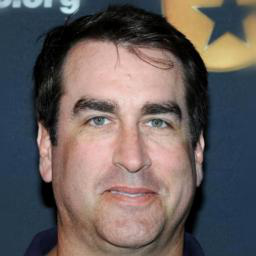

In [122]:
from google.colab import files
import PIL.Image as Image
import IPython.display
#@title #Upload your photo { display-mode: "form" }

print('Please upload your photo from computer')

uploaded = files.upload()
for fp in uploaded.keys():
  print('Upload file to test_imgs/{name}'.format(name=fp))

os.rename(fp, fp.replace(" ", ""))
fp = fp.replace(" ", "")
!mv $fp test_imgs/$fp
image_path = 'test_imgs/'+fp

original_image = Image.open(image_path)
original_image = original_image.convert("RGB")
display(original_image)

### Image Alignment

It is encouraged to first align and crop the image for better result. 

If your photo needs to be pre-processed, please select **run_align** and it will be done automatically using dlib.

In [107]:
# Setup required image transformations
run_align = True #@param {type:"boolean"}

EXPERIMENT_ARGS = {
    'transform' : transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
}
resize_dims = (256, 256)

Aligned image has shape: (256, 256)


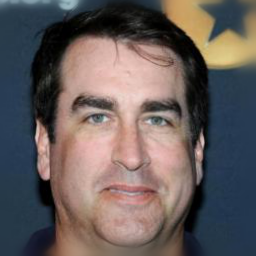

In [108]:
if  'shape_predictor_68_face_landmarks.dat' not in os.listdir():
    !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
    !bzip2 -dk shape_predictor_68_face_landmarks.dat.bz2

def run_alignment(image_path):
  import dlib
  from utils.alignment import align_face
  predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
  aligned_image = align_face(filepath=image_path, predictor=predictor) 
  print("Aligned image has shape: {}".format(aligned_image.size))
  return aligned_image 

if run_align:
  input_image = run_alignment(image_path)
else:
  input_image = original_image

input_image.resize(resize_dims)

In [109]:
img_transforms = EXPERIMENT_ARGS['transform']
transformed_image = img_transforms(input_image)

## Step 3: High-Fidelity Inversion

In [110]:
def display_alongside_source_image(result_image, source_image):
    res = np.concatenate([np.array(source_image.resize(resize_dims)),
                          np.array(result_image.resize(resize_dims))], axis=1)
    return Image.fromarray(res)

def get_latents(net, x, is_cars=False):
    codes = net.encoder(x)
    if net.opts.start_from_latent_avg:
        if codes.ndim == 2:
            codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)[:, 0, :]
        else:
            codes = codes + net.latent_avg.repeat(codes.shape[0], 1, 1)
    if codes.shape[1] == 18 and is_cars:
        codes = codes[:, :16, :]
    return codes

Inference took 0.0739 seconds.


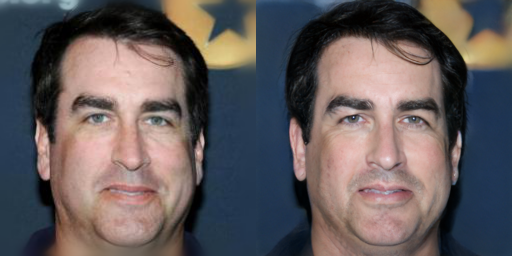

In [111]:
with torch.no_grad():
    x = transformed_image.unsqueeze(0).cuda()

    tic = time.time()
    latent_codes = get_latents(net, x)
    
    # calculate the distortion map
    imgs, _ = net.decoder([latent_codes[0].unsqueeze(0).cuda()],None, input_is_latent=True, randomize_noise=False, return_latents=True)
    res = x -  torch.nn.functional.interpolate(torch.clamp(imgs, -1., 1.), size=(256,256) , mode='bilinear')

    # ADA
    img_edit = torch.nn.functional.interpolate(torch.clamp(imgs, -1., 1.), size=(256,256) , mode='bilinear')
    res_align  = net.grid_align(torch.cat((res, img_edit  ), 1))

    # consultation fusion
    conditions = net.residue(res_align)

    result_image, _ = net.decoder([latent_codes],conditions, input_is_latent=True, randomize_noise=False, return_latents=True)
    toc = time.time()
    print('Inference took {:.4f} seconds.'.format(toc - tic))

# Display inversion:
display_alongside_source_image(tensor2im(result_image[0]), input_image)

## Step 4: High-Fidelity Editing

In [112]:
from editings import latent_editor
editor = latent_editor.LatentEditor(net.decoder)
# interface-GAN
INTERFACE_ATTRS = ['age', 'pose', 'smile']
# print(gender_bound)
interfacegan_directions = {
        'age': './editings/interfacegan_directions/age.pt',
        'smile': './editings/interfacegan_directions/smile.pt',
        'pose' : './editings/interfacegan_directions/pose.pt',
         }

Inference took 0.0438 seconds.


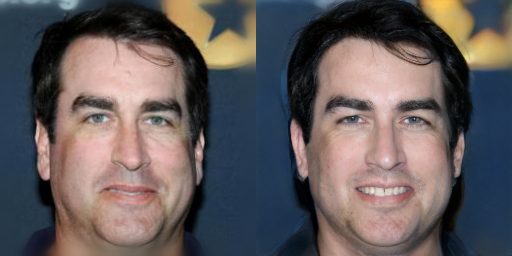

In [114]:
#@title #Adjust Interface attributes { display-mode: "form", run: "auto" }

age = -1.3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
# eyeglasses = 0 #@param {type:"slider", min:-2.9, max:3.0, step:0.1}
# gender = 2.4 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
pose = 0.3 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}
smile = 0.6 #@param {type:"slider", min:-3.0, max:3.0, step:0.1}

tic = time.time()
edit_latents = latent_codes[0].clone().detach().unsqueeze(0).cuda()

for i, attr_name in enumerate(INTERFACE_ATTRS):
  edit_direction = torch.load(interfacegan_directions[attr_name]).cuda()
  edit_latents += edit_direction * eval(attr_name)

with torch.no_grad():
    img_edit, _ = editor.generator([edit_latents], None, randomize_noise=False, input_is_latent=True)
# ADA
img_edit = torch.nn.functional.interpolate(torch.clamp(img_edit, -1., 1.), size=(256,256) , mode='bilinear')
res_align  = net.grid_align(torch.cat((res, img_edit  ), 1))
# consultation fusion
conditions = net.residue(res_align)
result, _ = net.decoder([edit_latents],conditions, input_is_latent=True, randomize_noise=False, return_latents=True)
result = torch.nn.functional.interpolate(result, size=(256,256) , mode='bilinear')
toc = time.time()
print('Inference took {:.4f} seconds.'.format(toc - tic))
display_alongside_source_image(tensor2im(result[0]), input_image)

In [ ]:
download_photo = True #@param {type:"boolean"}
file_name = 'myedit' #@param {type:"string"}
file_type = ".jpg" #@param ['.jpg', '.png']
if file_name == '':
  file_name = fp

tensor2im(result[0]).save('pics/' + file_name + file_type)

if download_photo == True:
  files.download('pics/' + file_name + file_type)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [115]:
# GANSpace
ganspace_pca = torch.load('./editings/ganspace_pca/ffhq_pca.pt') 
ganspace_directions = {
    'eyes':            (54,  7,  8,  20),
    'beard':           (58,  7,  9,  -20),
    'lip':             (34, 10, 11,  20) }            

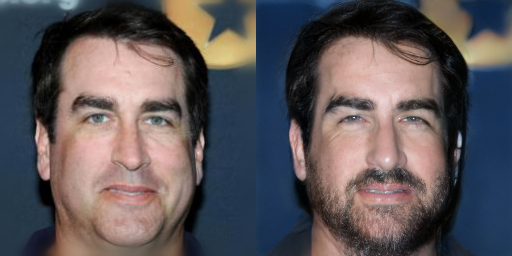

In [116]:
#@title #Select GANspace attributes { display-mode: "form", run: "auto" }
selected_attr = 'beard' #@param ['eyes', 'beard', 'lip']

edit_direction = ganspace_directions[selected_attr]

img_edit, edit_latents = editor.apply_ganspace(latent_codes[0].unsqueeze(0).cuda(), ganspace_pca, [edit_direction])
# align the distortion map
img_edit = torch.nn.functional.interpolate(torch.clamp(img_edit, -1., 1.), size=(256,256) , mode='bilinear')
res_align  = net.grid_align(torch.cat((res, img_edit  ), 1))
conditions = net.residue(res_align)
result, _ = net.decoder([edit_latents],conditions, input_is_latent=True, randomize_noise=False, return_latents=True)
result = torch.nn.functional.interpolate(result, size=(256,256) , mode='bilinear')
display_alongside_source_image(tensor2im(result[0]), input_image)

In [ ]:
download_photo = True #@param {type:"boolean"}
file_name = 'myedit2' #@param {type:"string"}
file_type = ".jpg" #@param ['.jpg', '.png']
if file_name == '':
  file_name = fp

tensor2im(result[0]).save('pics/' + file_name + file_type)

if download_photo == True:
  files.download('pics/' + file_name + file_type)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>